# Data Visualization Assignment \#2
Makeup for missed assignment in the Spring 2015 version of CSE 512, taught by Jeff Heer.

Katie Doroschak -- kdorosch@cs

I explored the contributions from PACs to campaigns over time using the 2015-2016 election cycle data.

In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import seaborn as sns
sns.set_style("white")

%matplotlib inline

## Import data

Use pandas to read the datasets, specifying headers based on the FEC data dictionaries.

In [2]:
cm_master_file = "data/cm.txt"
cm_header_file = "data/cm_header_file.csv"
cn_master_file = "data/cn.txt"
cn_header_file = "data/cn_header_file.csv"
contribs_file = "data/itpas2.txt"
contribs_header_file = "data/pas2_header_file.csv"
linkage_file = "data/ccl.txt"
linkage_header_file = "data/ccl_header_file.csv"

In [3]:
def date_parser(x):
    if x == 'nan':
        return np.NaN
    return pd.datetime.strptime(str(x), '%m%d%Y')

In [4]:
def read_FEC_data(data_file, header_file, date_cols=False, date_parser=None):
    with open(header_file, "r") as f:
        headers = f.readlines()[0].split(",")
    data = pd.read_csv(data_file, delimiter="|",header=None, parse_dates=date_cols, date_parser=date_parser)
    data.columns = headers
    return data

In [32]:
cm = read_FEC_data(cm_master_file, cm_header_file)
cn = read_FEC_data(cn_master_file, cn_header_file)
contribs = read_FEC_data(contribs_file, contribs_header_file, date_cols=[13], date_parser=date_parser)
linkage = read_FEC_data(linkage_file, linkage_header_file)

## Basic data exploration

* What columns do the files have in common? Especially for contributions from committees to candidates and linkages between committees and candidates.

* How many candidates are there?

* What is the distribution of contributions to candidates?

In [6]:
print "Columns shared btw contribs & cmte's:", set(contribs.columns).intersection(set(cm.columns))
print "Columns shared btw contribs & cands:", set(contribs.columns).intersection(set(cn.columns))
print "Columns shared btw linkage & cmte's:", set(linkage.columns).intersection(set(cm.columns))
print "Columns shared btw linkage & cands:", set(linkage.columns).intersection(set(cn.columns))

Columns shared btw contribs & cmte's: set(['CMTE_ID'])
Columns shared btw contribs & cands: set(['CAND_ID'])
Columns shared btw linkage & cmte's: set(['CMTE_ID', 'CMTE_DSGN', 'CMTE_TP'])
Columns shared btw linkage & cands: set(['CAND_ID', 'CAND_ELECTION_YR'])


This (perhaps obviously) confirms that we can do a multi-way join on the candidates, committees, and contributions, and separately, the candidates, committees, and linkage assuming the IDs are the same across all.

In [7]:
print "There are:\n  %d candidates" % len(cn)
print "  %d committees" % len(cm)
print "  %d links between candidates & committees" % len(linkage)
print "  %d contributions from committees to candidates" % len(contribs)

There are:
  7645 candidates
  17817 committees
  6426 links between candidates & committees
  514637 contributions from committees to candidates


Let's try plotting the number of contributions made by each committee. I expect that most of them will have made just a few contributions. 

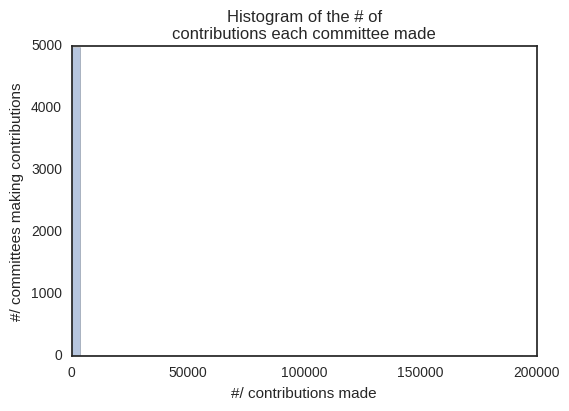

In [8]:
ctb_per_cm = contribs["CMTE_ID"].value_counts()
fig,ax = plt.subplots(figsize=(6,4))
ax = sns.distplot(list(ctb_per_cm), ax=ax, kde=False)
ax.set_title("Histogram of the # of\ncontributions each committee made")
ax.set_xlabel("#/ contributions made")
ax.set_ylabel("#/ committees making contributions")

This plot does a horrible job of showing... anything.
Why is this? Let's do a visual check for outliers:

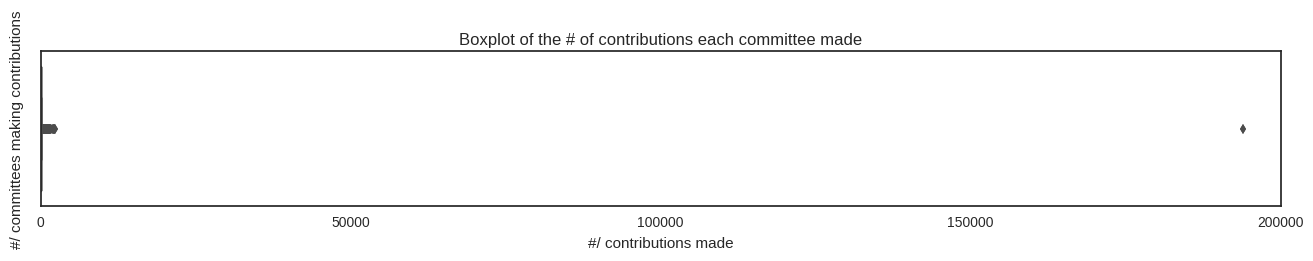

In [9]:
fig,ax = plt.subplots(figsize=(16,2))
ax = sns.boxplot(list(ctb_per_cm), ax=ax)
ax.set_title("Boxplot of the # of contributions each committee made")
ax.set_xlabel("#/ contributions made")
ax.set_ylabel("#/ committees making contributions")
sns.boxplot(list(ctb_per_cm))

Looks like the x axis is overdispersed due to a single outlier -- one committee gave nearly 200k contributions. Even in an extremely wide plot, we can't see *anything* with respect to nearly all of the data points.
Let's get rid of this and see what the actual distribution looks like.

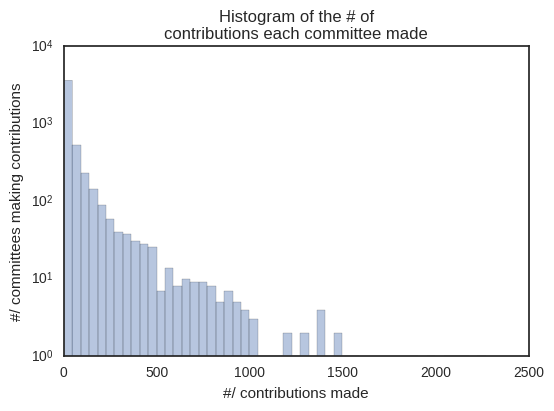

In [10]:
ctb_per_cm_le50k = ctb_per_cm[ctb_per_cm < 50000]
fig,ax = plt.subplots(figsize=(6,4))
ax = sns.distplot(list(ctb_per_cm_le50k), ax=ax, kde=False)
ax.set_title("Histogram of the # of\ncontributions each committee made")
ax.set_xlabel("#/ contributions made")
ax.set_ylabel("#/ committees making contributions")
ax.set_yscale("log")

#### This isn't as interesting as I thought...

Because so many committees make so few contributions, let's look at the total volume of contributions by date instead.

### New question: How does the total contribution amount change as the election date approaches?

Join candidates and contributions on candidate ID.

I will need the columns: transaction amount, transaction date

I will also draw a line representing the election day in 2016.

(Since this plot is exploratory, it won't necessarily follow good data visualization principles.)

In [11]:
election_day = "2016-11-8"

In [12]:
contribs_by_day = contribs[["TRANSACTION_DT", "TRANSACTION_AMT"]].groupby(by=["TRANSACTION_DT"]).sum()
contribs_by_day["TRANSACTION_DT"] = contribs_by_day.index
contribs_by_day.index = range(len(contribs_by_day))
contribs_by_day = contribs_by_day.dropna()
contribs_by_day = contribs_by_day[contribs_by_day.TRANSACTION_DT > "2015-01-01"]
contribs_by_day = contribs_by_day[contribs_by_day.TRANSACTION_DT < "2017-01-01"]

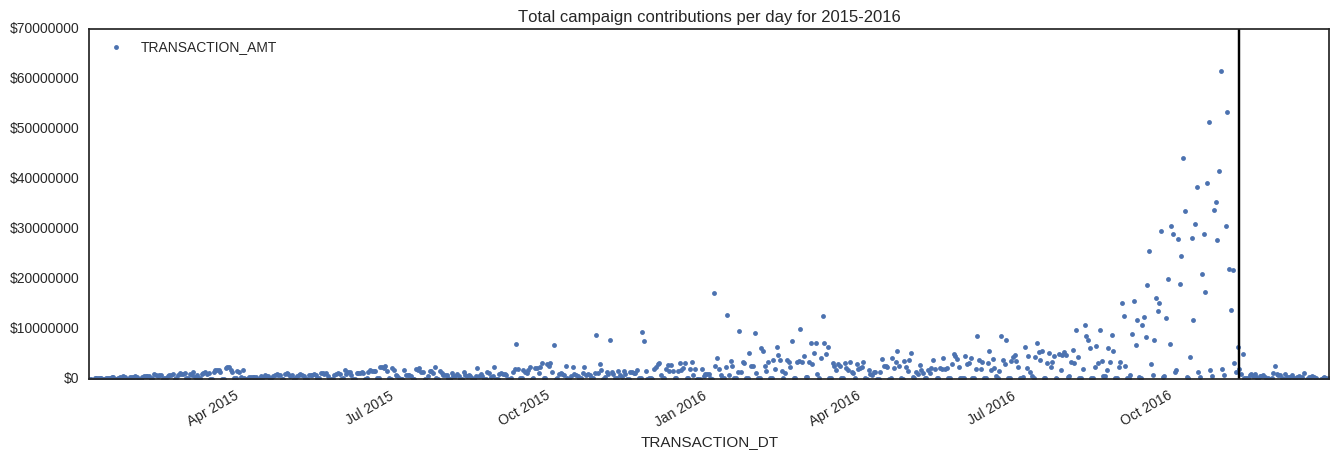

In [13]:
ax = contribs_by_day.plot(x="TRANSACTION_DT", y="TRANSACTION_AMT", figsize=(16,5), style=".")
ax.axvline(x=election_day, color="black")
ax.set_title("Total campaign contributions per day for 2015-2016")
ax.set_ylim(0, ax.get_ylim()[1])
# ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter(FormatStrFormatter('$%d'))

#### A note on negative contributions

Oddly, there are some campaign contributions that are negative. According to the FAQ on the FEC's website, these represent returned checks or bounced checks. The description explicitly excludes returned contributions, meaning that the sign of these contributions is an indicator of an attempted but failed contribution, and therefore were *never counted as positive*. I believe the appropriate action is to discard these transactions, and will do so from this point on in the notebook.

### Question: How does this plot change if we split the contributions by political party?

Join candidates and contributions on candidate ID.

I will need the columns: transaction amount, transaction date, candidate political party

In [18]:
contribs_w_cn = contribs.join(cn.set_index(cn.CAND_ID), on="CAND_ID", lsuffix="_ctb", rsuffix="_cn", how="inner")

ctb_day_party = contribs_w_cn[["TRANSACTION_DT", "TRANSACTION_AMT", "CAND_PTY_AFFILIATION"]]
ctb_day_party = ctb_day_party[ctb_day_party.TRANSACTION_AMT > 0]
ctb_day_party = ctb_day_party.groupby(["TRANSACTION_DT", "CAND_PTY_AFFILIATION"]).sum()
ctb_day_party.reset_index(inplace=True)

ctb_day_party = ctb_day_party.dropna()
ctb_day_party = ctb_day_party[ctb_day_party.TRANSACTION_DT > "2015-01-01"]
ctb_day_party = ctb_day_party[ctb_day_party.TRANSACTION_DT < "2017-01-01"]

Check which parties candidates are affiliated with.

In [19]:
np.unique(ctb_day_party.CAND_PTY_AFFILIATION)

array(['CON', 'CRV', 'DEM', 'DFL', 'GRE', 'IDP', 'IND', 'LIB', 'NNE',
       'NPP', 'OTH', 'REP', 'UNK', 'W', 'WFP'], dtype=object)

Coming from Minnesota, I know that the Democratic party is actually called "DFL" there (Democratic Farmer-Labor party), so I'll go ahead and merge those. Otherwise, I just want to compare the two main parties.

In [20]:
ctb_day_party = ctb_day_party.replace("DFL", "DEM")
ctb_day_party = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"].isin(["DEM", "REP"])]

In [21]:
np.unique(ctb_day_party.CAND_PTY_AFFILIATION)

array(['DEM', 'REP'], dtype=object)

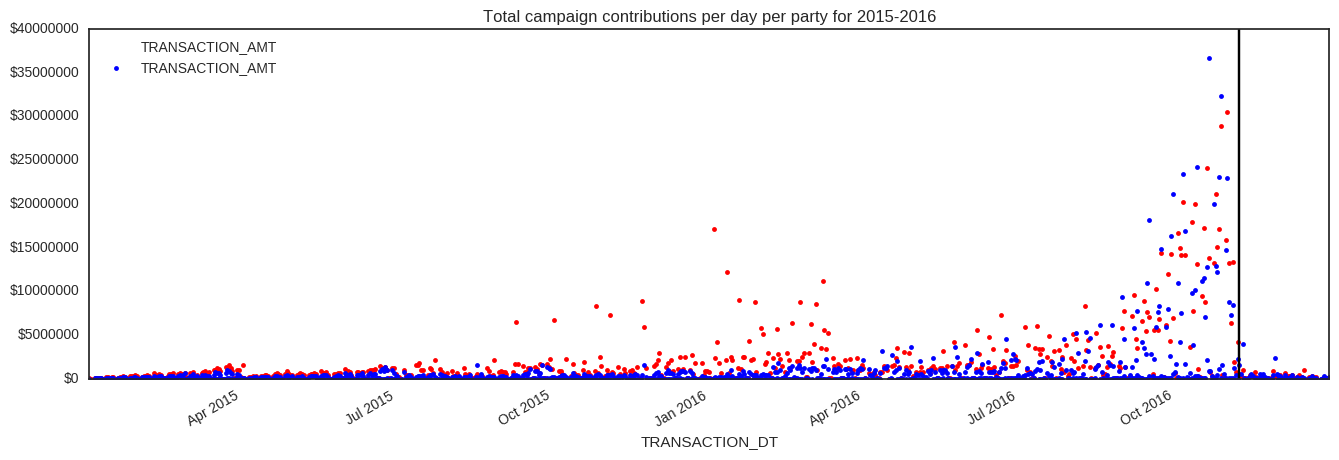

In [22]:
dem_ctb = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"] == "DEM"]
rep_ctb = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"] == "REP"]
fig, ax = plt.subplots()
ax = rep_ctb.plot(x="TRANSACTION_DT", y="TRANSACTION_AMT", figsize=(16,5), style=".", color="red", ax=ax)
ax = dem_ctb.plot(x="TRANSACTION_DT", y="TRANSACTION_AMT", figsize=(16,5), style=".", color="blue", ax=ax)

ax.axvline(x=election_day, color="black")
ax.set_title("Total campaign contributions per day per party for 2015-2016")
ax.set_ylim(0, ax.get_ylim()[1])
# ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

ax.yaxis.set_major_formatter(FormatStrFormatter('$%d'))
plt.show()

Interesting. Let's use a log plot to see what the trends are like on the low end.

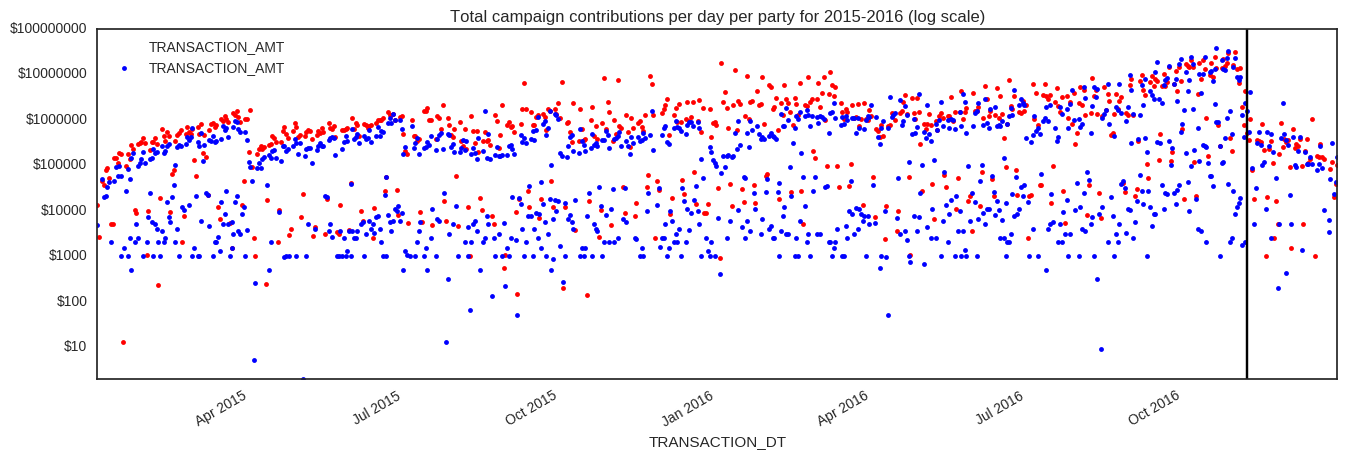

In [23]:
dem_ctb = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"] == "DEM"]
rep_ctb = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"] == "REP"]
fig, ax = plt.subplots()
ax = rep_ctb.plot(x="TRANSACTION_DT", y="TRANSACTION_AMT", figsize=(16,5), style=".", color="red", ax=ax)
ax = dem_ctb.plot(x="TRANSACTION_DT", y="TRANSACTION_AMT", figsize=(16,5), style=".", color="blue", ax=ax)

ax.axvline(x=election_day, color="black")
ax.set_title("Total campaign contributions per day per party for 2015-2016 (log scale)")
ax.set_yscale("log")
ax.set_ylim(0, ax.get_ylim()[1])

ax.yaxis.set_major_formatter(FormatStrFormatter('$%d'))
plt.show()

## Splitting the y axis

A log plot makes the trends easier to see, but we don't naturally or easily think of money in terms of logs. This makes it less interpretable. One option is to create two different scales on the y axis -- one for the lower amounts, and another plot on top with a different scale for the larger amounts. Let's try this out.

I will also make the dollar amounts more readable by formatting them as \$10M instead of $10000000.

In [24]:
dem_ctb = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"] == "DEM"]
rep_ctb = ctb_day_party.loc[ctb_day_party["CAND_PTY_AFFILIATION"] == "REP"]

In [25]:
max_ax1 = 3000000
dem_ax1 = dem_ctb.loc[dem_ctb["TRANSACTION_AMT"]< max_ax1]
rep_ax1 = rep_ctb.loc[rep_ctb["TRANSACTION_AMT"]< max_ax1]
dem_ax0 = dem_ctb.loc[dem_ctb["TRANSACTION_AMT"]> max_ax1]
rep_ax0 = rep_ctb.loc[rep_ctb["TRANSACTION_AMT"]> max_ax1]

(3000000, 40000000.0)

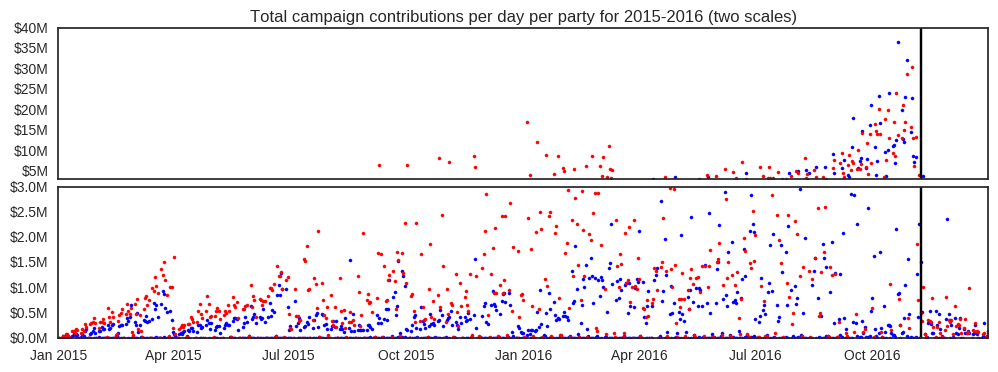

In [26]:
fig, axarr = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,1], 'hspace':0.05}, figsize=(12,4))
ax0, ax1 = axarr

rep_color = "red"
dem_color = "blue"
rep_marker = "."
dem_marker = "."

ax1.scatter(x=list(dem_ax1["TRANSACTION_DT"]), y=list(dem_ax1["TRANSACTION_AMT"]), color=dem_color, marker=dem_marker)
ax1.scatter(x=list(rep_ax1["TRANSACTION_DT"]), y=list(rep_ax1["TRANSACTION_AMT"]), color=rep_color, marker=rep_marker)
ax0.scatter(x=list(dem_ax0["TRANSACTION_DT"]), y=list(dem_ax0["TRANSACTION_AMT"]), color=dem_color, marker=dem_marker)
ax0.scatter(x=list(rep_ax0["TRANSACTION_DT"]), y=list(rep_ax0["TRANSACTION_AMT"]), color=rep_color, marker=rep_marker)
ax0.axvline(x=election_day, color="black")
ax1.axvline(x=election_day, color="black")


ax0.set_title("Total campaign contributions per day per party for 2015-2016 (two scales)")

## Set axes
# X axis (dates)
datemin = datetime.date(2015, 1, 1)
datemax = datetime.date(2016, 12, 31)
ax1.set_xlim(datemin, datemax)
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax1.format_xdata = date_fmt

# Y axis ($M, split)
def millions_dec(x, pos):
    return '$%1.1fM' % (x*1e-6)
def millions(x, pos):
    return '$%1dM' % (x*1e-6)
mil_dec_fmt = FuncFormatter(millions_dec)
mil_fmt = FuncFormatter(millions)
ax0.yaxis.set_major_formatter(mil_fmt)
ax1.yaxis.set_major_formatter(mil_dec_fmt)

ax1.set_ylim(0, max_ax1)
ax0.set_ylim(max_ax1, ax0.get_ylim()[1])

## Visualizing trends in the data

It is clear that there is some kind of trend, but it is not immediately obvious. To be more effective, I'll try adding:

* Trend lines representing a rolling window of days
* Important dates of debates/conventions/etc
* Label for election day

Other data visualization improvements:

* Remove chart junk -- borders are unnecessary
* Lighten the dividing line between the subplots

There is also a strange problem with the y axis labeling -- the bottom line of the top plot is actually at \$3M, but the lowest label on the top is \$5M, even though it doesn't represent the bottom.

In [27]:
max_ax1 = 3000000
dem_ax1 = dem_ctb.loc[dem_ctb["TRANSACTION_AMT"]< max_ax1]
rep_ax1 = rep_ctb.loc[rep_ctb["TRANSACTION_AMT"]< max_ax1]
dem_ax0 = dem_ctb.loc[dem_ctb["TRANSACTION_AMT"]> max_ax1]
rep_ax0 = rep_ctb.loc[rep_ctb["TRANSACTION_AMT"]> max_ax1]
dem_trend = dem_ctb.rolling(window=14, on="TRANSACTION_DT").mean()
rep_trend = rep_ctb.rolling(window=14, on="TRANSACTION_DT").mean()

In [28]:
prim_cauc = pd.read_csv("data/primaries_caucuses.txt",header=None)
prim_cauc.columns = ["date", "count", " "]
prim_cauc["date"] = prim_cauc["date"].str.strip()
prim_cauc["date"] = prim_cauc["date"].astype(str) + "-2016"
prim_cauc["date"] = pd.to_datetime(prim_cauc["date"])

debates = pd.read_csv("data/debates_conventions.txt",header=None)
debates.columns = ["date", " ", "event"]
debates["date"] = debates["date"].str.strip()
debates["date"] = debates["date"].astype(str) + "-2016"
debates["date"] = pd.to_datetime(debates["date"])

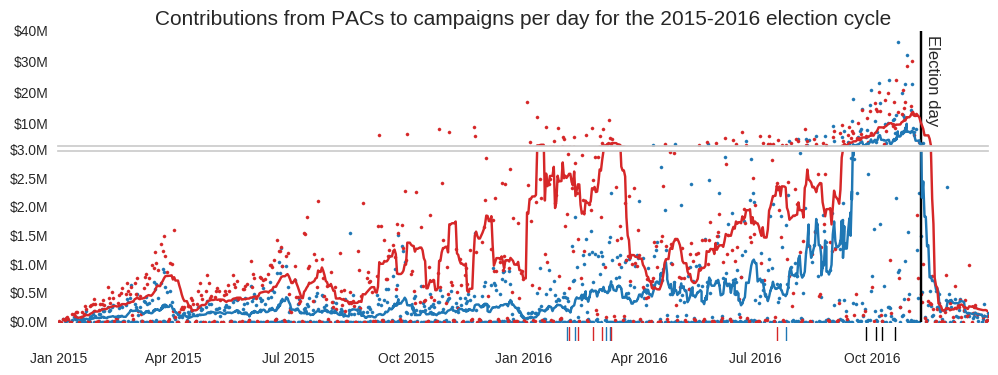

In [29]:
fig, axarr = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, \
                          gridspec_kw={'height_ratios':[4,6,0.5], 'hspace':0.05}, figsize=(12,4))
ax0, ax1, ax2 = axarr

rep_color = (0.83921, 0.15294, 0.15686)
dem_color = (0.12156, 0.46666, 0.70588)
rep_marker = "."
dem_marker = "."

ax1.scatter(x=list(dem_ax1["TRANSACTION_DT"]), y=list(dem_ax1["TRANSACTION_AMT"]), color=dem_color, marker=dem_marker)
ax1.scatter(x=list(rep_ax1["TRANSACTION_DT"]), y=list(rep_ax1["TRANSACTION_AMT"]), color=rep_color, marker=rep_marker)
ax0.scatter(x=list(dem_ax0["TRANSACTION_DT"]), y=list(dem_ax0["TRANSACTION_AMT"]), color=dem_color, marker=dem_marker)
ax0.scatter(x=list(rep_ax0["TRANSACTION_DT"]), y=list(rep_ax0["TRANSACTION_AMT"]), color=rep_color, marker=rep_marker)
ax0.axvline(x=election_day, color="black")
ax1.axvline(x=election_day, color="black")
ax0.text("2016-11-11", 35000000, "Election day", fontsize=12, rotation=270)
ax1.plot(dem_trend["TRANSACTION_DT"], dem_trend["TRANSACTION_AMT"], color=dem_color)
ax0.plot(dem_trend["TRANSACTION_DT"], dem_trend["TRANSACTION_AMT"], color=dem_color)
ax1.plot(rep_trend["TRANSACTION_DT"], rep_trend["TRANSACTION_AMT"], color=rep_color)
ax0.plot(rep_trend["TRANSACTION_DT"], rep_trend["TRANSACTION_AMT"], color=rep_color)


ax0.set_title("Contributions from PACs to campaigns per day for the 2015-2016 election cycle", fontsize=15)

## Set axes
# X axis (dates)
datemin = datetime.date(2015, 1, 1)
datemax = datetime.date(2016, 12, 31)
ax1.set_xlim(datemin, datemax)
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax1.format_xdata = date_fmt

# Y axis ($M, split)
def millions_dec(x, pos):
    return '$%1.1fM' % (x*1e-6)
def millions(x, pos):
    return '$%1dM' % (x*1e-6)
mil_dec_fmt = FuncFormatter(millions_dec)
mil_fmt = FuncFormatter(millions)
ax0.yaxis.set_major_formatter(mil_fmt)
ax1.yaxis.set_major_formatter(mil_dec_fmt)

ax1.set_ylim(0, max_ax1)
ax0.set_ylim(max_ax1, ax0.get_ylim()[1])

# ax0.set_yticks(ax0.get_yticks()[2:])
# ax0.set_yticks(ax0.get_yticks()[2:])
yticks = ax0.get_yticks()
yticks = [y for i,y in enumerate(yticks) if i in [2,4,6,8]]
# yticks[0].label1.set_visible(False)
ax0.set_yticks(yticks)


# Borders -- just leave the middle gap
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

ax1.spines["top"].set_color("#cccccc")
ax0.spines["bottom"].set_color("#cccccc")
# ax1.text(0, 0, "Total contributions per day", rotation=0)

## Add & format events

ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_yticklabels([])
for row in debates.iterrows():
    dt = row[1].date
    party = row[1].event.split("-")[0].strip()
    if party == "DEM":
        color = dem_color
    elif party == "REP":
        color = rep_color
    else:
        color= "black"
    ax2.axvline(dt, color=color, lw=1)
# for dt in prim_cauc["date"]:
#     ax2.axvline(dt, color = "black", lw=1)

# Final plot

The extra dates don't add much information and are not interpretable without a lot of context, so I'll leave those out.

Although red & blue are both standard for Republicans and Democrats in the world of politics, the trend line especially needs to be labeled so I include the parties there too. I can also make the title less complex by adding the "1 day contribution" label to the legend.

Labels should be bigger, and it's not clear where exactly "Oct 2015" falls on the line, so ticks are added back in for the labeled months only.

In [30]:
max_ax1 = 3000000
dem_ax1 = dem_ctb.loc[dem_ctb["TRANSACTION_AMT"]< max_ax1]
rep_ax1 = rep_ctb.loc[rep_ctb["TRANSACTION_AMT"]< max_ax1]
dem_ax0 = dem_ctb.loc[dem_ctb["TRANSACTION_AMT"]> max_ax1]
rep_ax0 = rep_ctb.loc[rep_ctb["TRANSACTION_AMT"]> max_ax1]
dem_trend = dem_ctb.rolling(window=14, on="TRANSACTION_DT").mean()
rep_trend = rep_ctb.rolling(window=14, on="TRANSACTION_DT").mean()

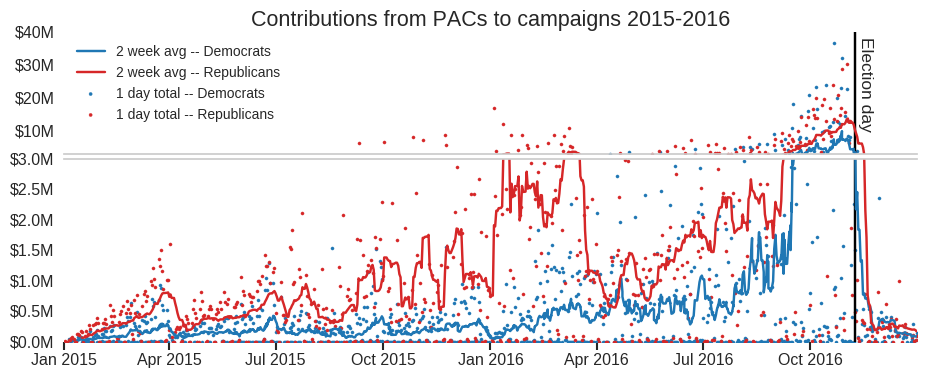

In [31]:
fig, axarr = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, \
                          gridspec_kw={'height_ratios':[4,6], 'hspace':0.03}, figsize=(11,4))
ax0, ax1= axarr

rep_color = (0.83921, 0.15294, 0.15686)
dem_color = (0.12156, 0.46666, 0.70588)
rep_marker = "."
dem_marker = "."

ax1.scatter(x=list(dem_ax1["TRANSACTION_DT"]), y=list(dem_ax1["TRANSACTION_AMT"]), color=dem_color, marker=dem_marker)
ax1.scatter(x=list(rep_ax1["TRANSACTION_DT"]), y=list(rep_ax1["TRANSACTION_AMT"]), color=rep_color, marker=rep_marker)
ax0.scatter(x=list(dem_ax0["TRANSACTION_DT"]), y=list(dem_ax0["TRANSACTION_AMT"]), color=dem_color, marker=dem_marker, label="1 day total -- Democrats")
ax0.scatter(x=list(rep_ax0["TRANSACTION_DT"]), y=list(rep_ax0["TRANSACTION_AMT"]), color=rep_color, marker=rep_marker, label="1 day total -- Republicans")
ax0.axvline(x=election_day, color="black")
ax1.axvline(x=election_day, color="black")
ax0.text("2016-11-11", 35000000, "Election day", fontsize=12.5, rotation=270)
ax1.plot(dem_trend["TRANSACTION_DT"], dem_trend["TRANSACTION_AMT"], color=dem_color, label="DEM 2wk avg")
ax0.plot(dem_trend["TRANSACTION_DT"], dem_trend["TRANSACTION_AMT"], color=dem_color, label="2 week avg -- Democrats")
ax1.plot(rep_trend["TRANSACTION_DT"], rep_trend["TRANSACTION_AMT"], color=rep_color, label="REP 2wk avg")
ax0.plot(rep_trend["TRANSACTION_DT"], rep_trend["TRANSACTION_AMT"], color=rep_color, label="2 week avg -- Republicans")


ax0.set_title("Contributions from PACs to campaigns 2015-2016", fontsize=15.5)

## Set axes
# X axis (dates)
datemin = datetime.date(2015, 1, 1)
datemax = datetime.date(2016, 12, 31)
ax1.set_xlim(datemin, datemax)
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax1.format_xdata = date_fmt

# Y axis ($M, split)
def millions_dec(x, pos):
    return '$%1.1fM' % (x*1e-6)
def millions(x, pos):
    return '$%1dM' % (x*1e-6)
mil_dec_fmt = FuncFormatter(millions_dec)
mil_fmt = FuncFormatter(millions)
ax0.yaxis.set_major_formatter(mil_fmt)
ax1.yaxis.set_major_formatter(mil_dec_fmt)

ax1.set_ylim(0, max_ax1)
ax0.set_ylim(max_ax1, ax0.get_ylim()[1])

yticks = ax0.get_yticks()
yticks = [y for i,y in enumerate(yticks) if i in [2,4,6,8]]
ax0.set_yticks(yticks)
ax0.tick_params(labelsize=11.5)
ax1.tick_params(labelsize=11.5)

# Borders -- just leave the middle gap
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

ax1.spines["top"].set_color("#cccccc")
ax0.spines["bottom"].set_color("#cccccc")

ax1.tick_params(axis='x', which='major', bottom="on", top="off", direction='out', length=6, width=1.5)

legend = ax0.legend(loc='upper left')

fig.savefig("a2-kdorosch.png", bbox_inches="tight")